# [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

### Цель: 
- Научиться распознавать мошеннические транзакции.

Датасет содержит транзакции, совершенные держателями карт из Европы, за два дня в сентябре 2013 года. Имеем 492 мошенничества из 284 807 транзакций. Мошеннические транзакции совершаются намного реже, чем легальные. Соответсвенно дасет имеет сильный дисбаланс. На положительный класс (мошенничество) приходится всего 0,172% всех транзакций.

#### Свойства датасета:
- V1, V2, … V28 — основные компоненты полученные в результате PCA преобразования. Исходные свойства обфусцированы из соображений конфеденциальности.
- Time — время транзакции в секундах относительно первой транзакции в датасете 
- Amount — сумма перевода.
- Class — 1 мошенническая транзакция (fraud), легитимная 0 

## Импорт

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, average_precision_score, roc_curve, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.naive_bayes import GaussianNB

## Быстрая проверка данных

In [2]:
df = pd.read_csv("../input/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(f'строк: {df.shape[0]}, столбцов: {df.shape[1]}')

строк: 284807, столбцов: 31


- ### пропусков нет

In [5]:
df.isna().sum().sum()

0

- ### количество классов два как и ожидалось

In [6]:
df["Class"].nunique()

2

- ### дисбаланс данных

In [7]:
df.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [8]:
print(f'мошеннические транзакции составляют {round(492 / 284315 * 100, 2)}% от легитимных транзакций')

мошеннические транзакции составляют 0.17% от легитимных транзакций


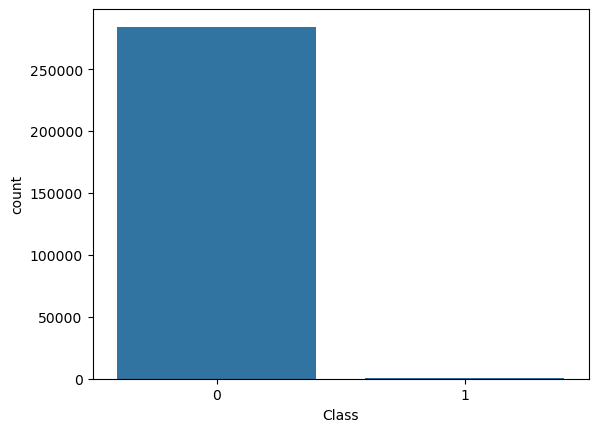

In [9]:
sns.countplot(df, x='Class')
plt.show()

## Исследование данных

Функция для вывода гистограммы и плотности свойств с разделением по классам.

In [10]:

def plot_per_class_distributions(feature):
    df0 = df[df["Class"] == 0] # NoFraud
    df1 = df[df["Class"] == 1] # Fraud
    sns.histplot(
        df0[feature],
        bins=50,
        color="r",
        kde=True,
        stat="density",
        linewidth=0,
        label="NoFraud",
    )
    sns.histplot(
        df1[feature],
        bins=50,
        color="b",
        kde=True,
        stat="density",
        linewidth=0,
        label="Fraud",
    )
    plt.title(feature)
    plt.legend()
    plt.show()

### Отрисуем распределения свойств V1—V28 с разделением по классам.

In [28]:
features = [f"V{i}" for i in range(1, 29)]

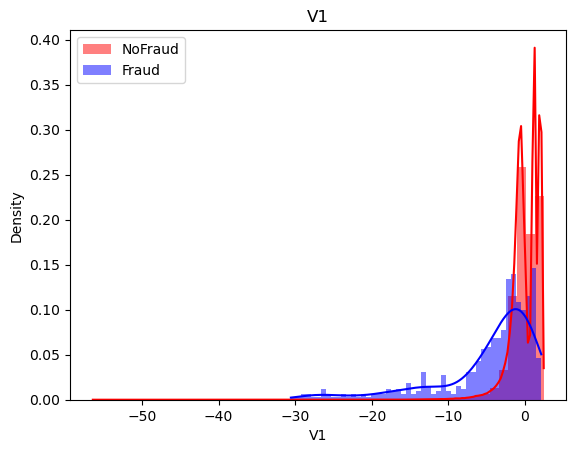

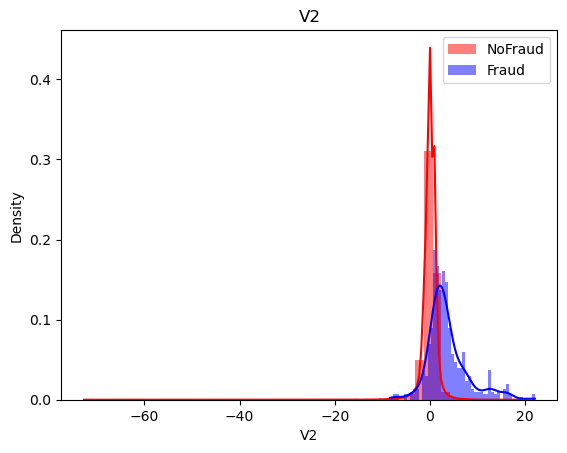

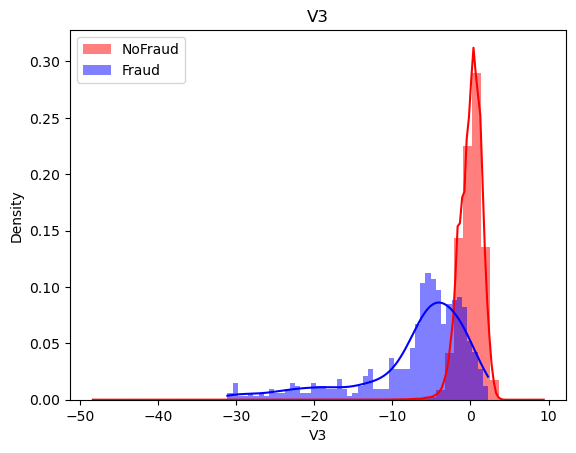

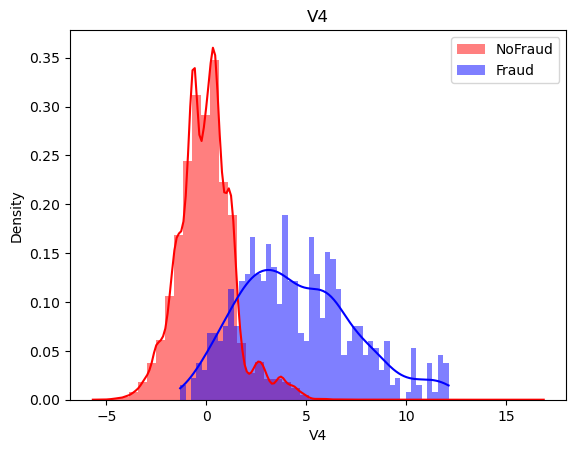

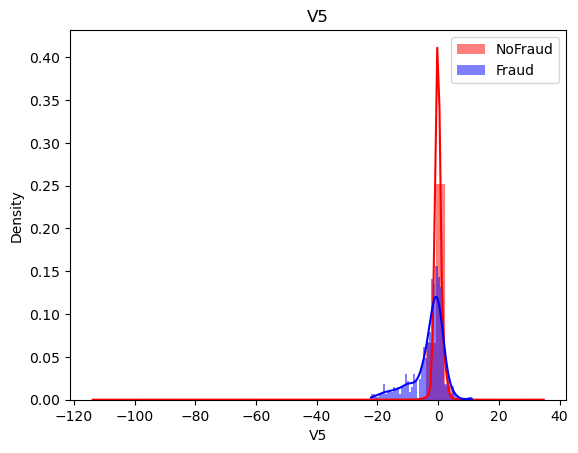

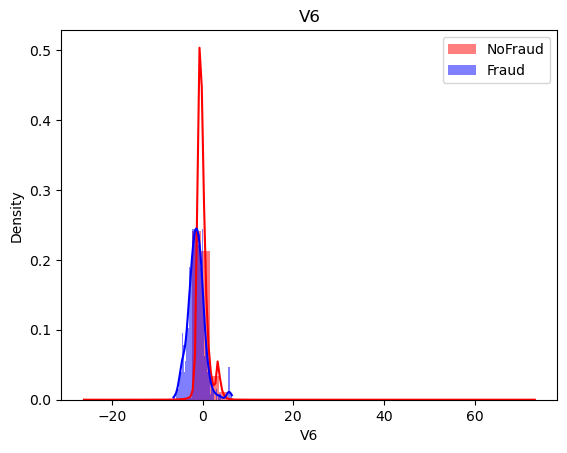

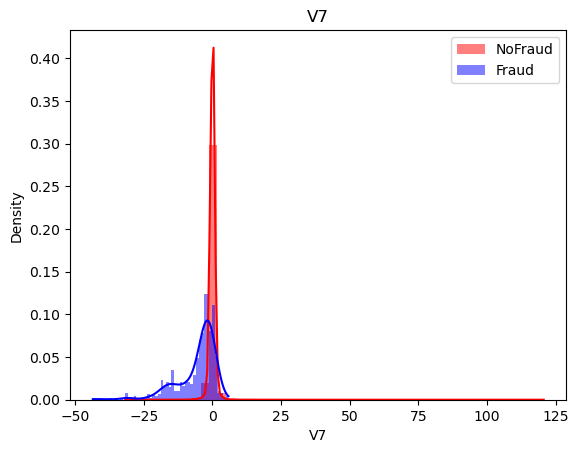

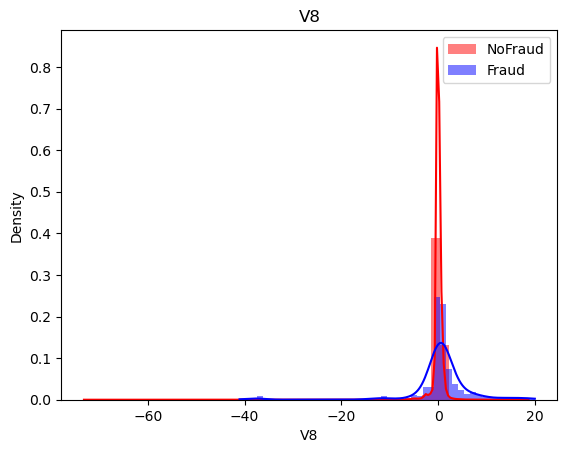

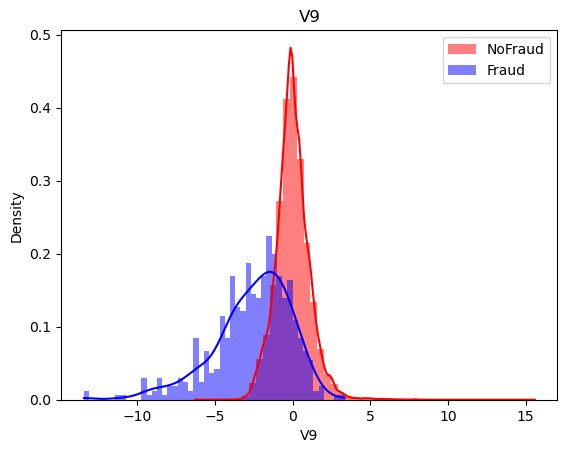

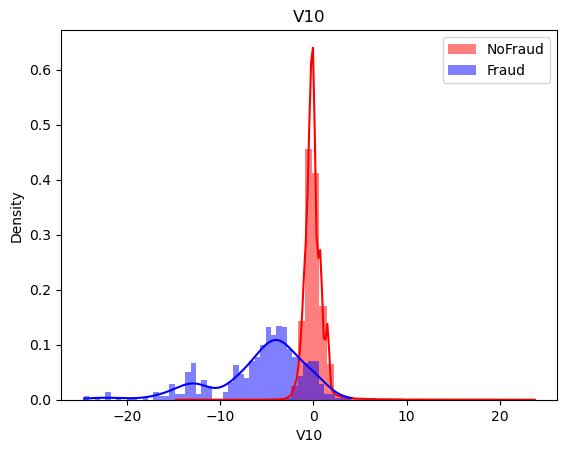

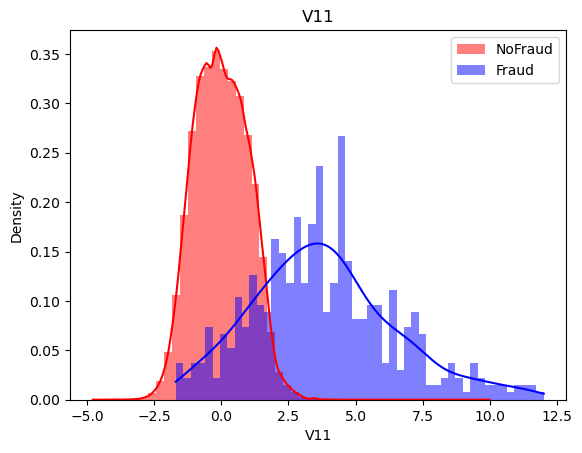

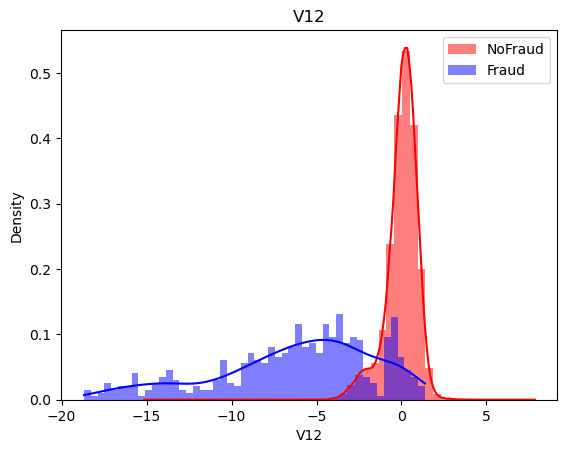

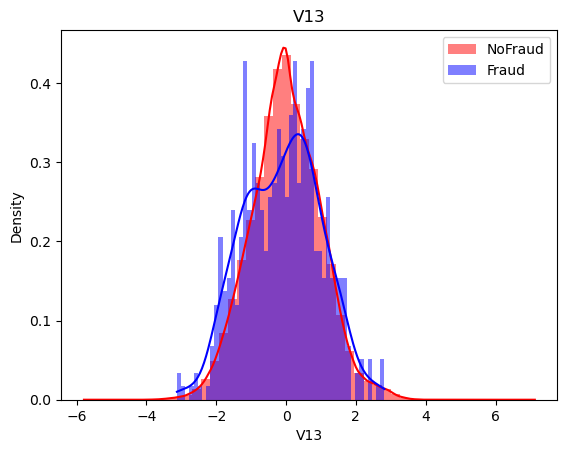

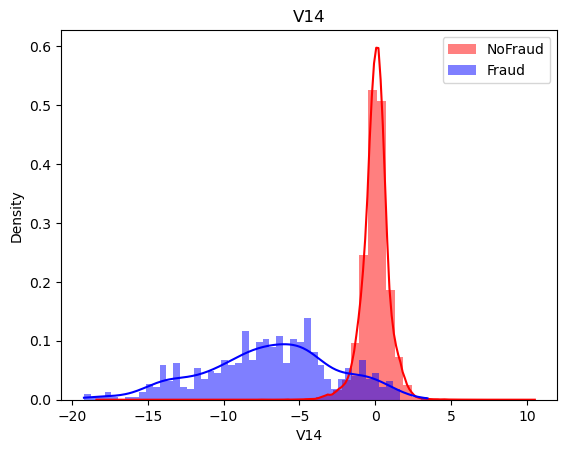

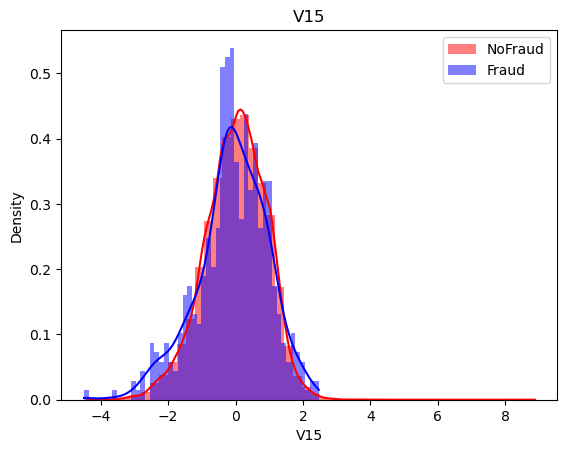

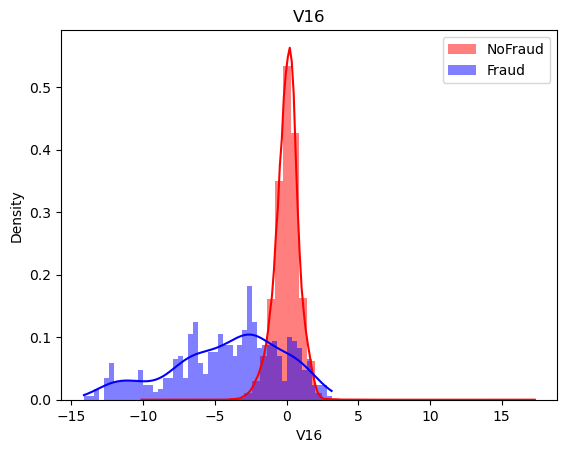

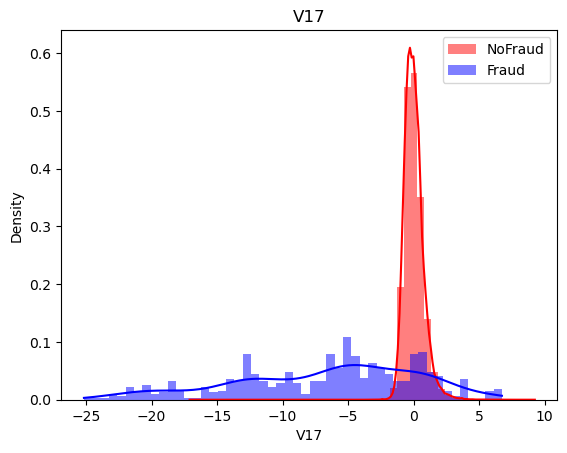

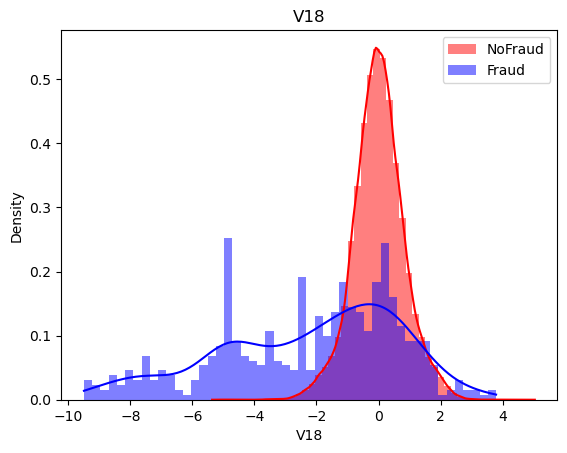

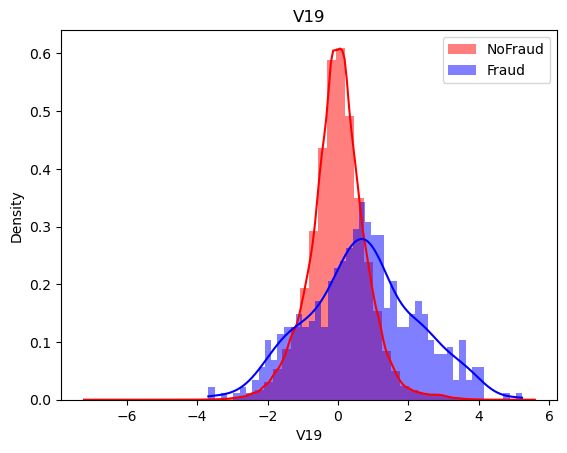

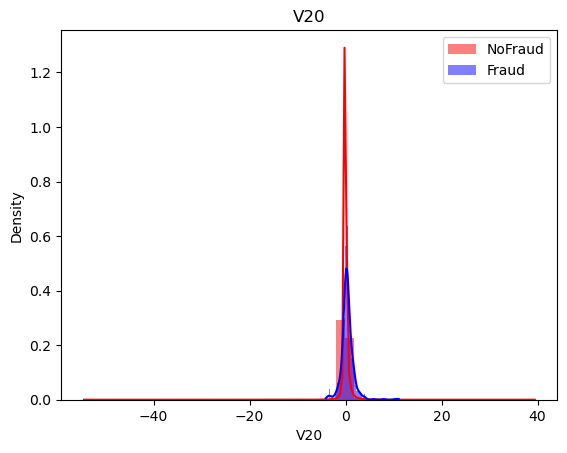

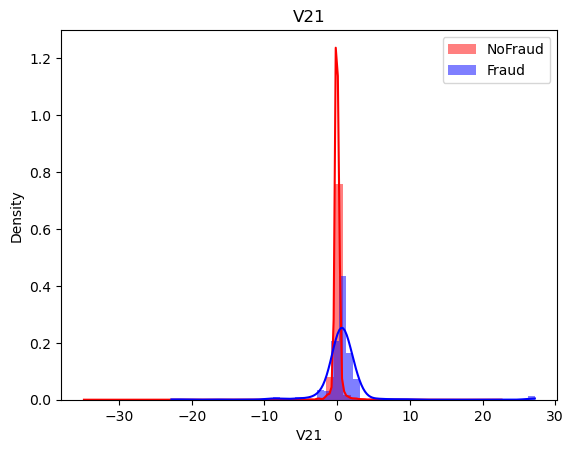

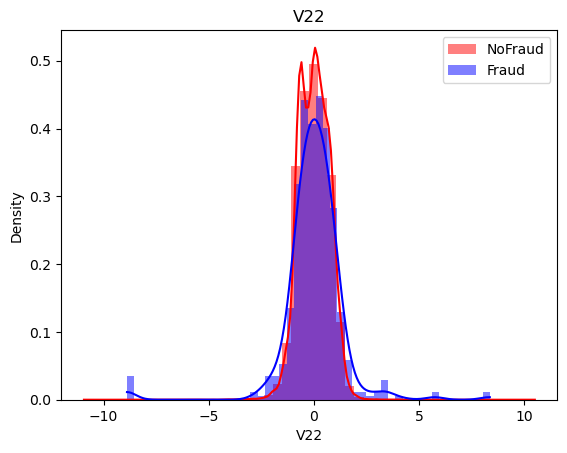

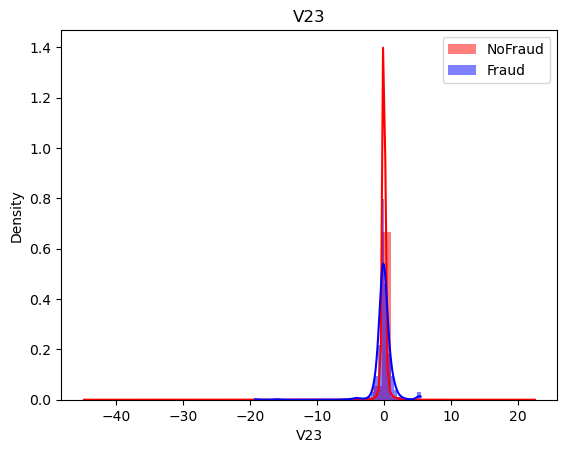

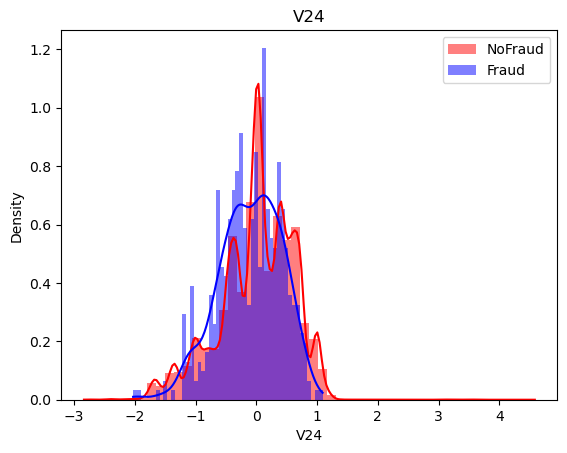

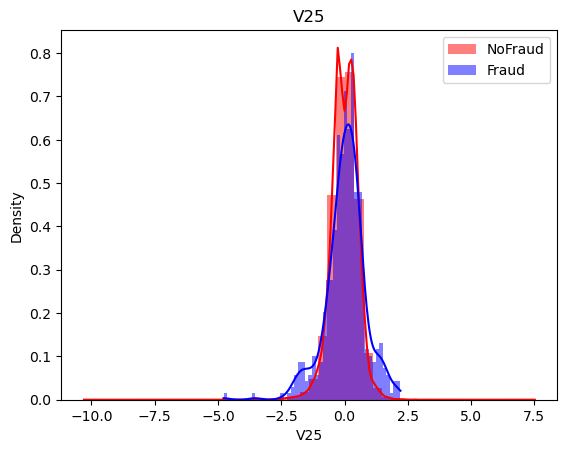

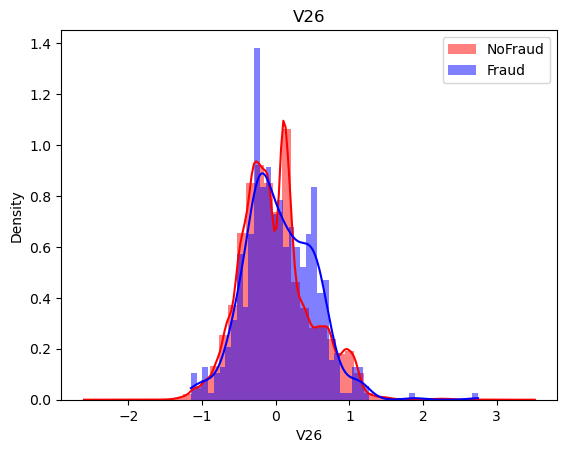

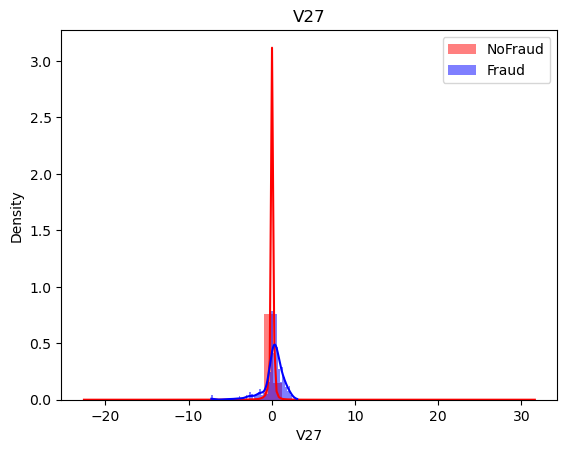

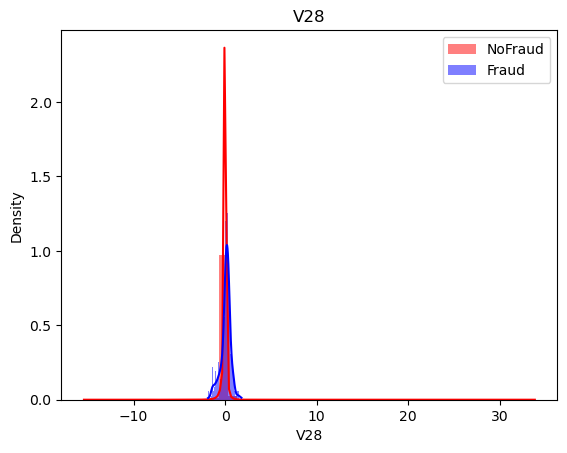

In [29]:
for feature in features:
    plot_per_class_distributions(feature)

Некоторые свойства хорошо разделены по классам. Сойства V4, V11 имеют чёткое разделение. Их распределения для классов 0 и 1 почти не пересекаются. V12, V14, V18 частично разделены, V1, V2, V3, V10 имеют отчётливый профиль. Свойства V25, V26, V28 имеют похожие профили для обоих значений классов. Cвойства V1 - V28 для законных транзакций имеют средние значения близкие к нулю. По распределениям это хорошо видно. Те же свойства мошеннических транзакций имеют асимметричное распределение.

In [30]:
f = [f"V{i}" for i in range(1, 29)]
df[df['Class'] == 0][f].mean()

V1     0.008258
V2    -0.006271
V3     0.012171
V4    -0.007860
V5     0.005453
V6     0.002419
V7     0.009637
V8    -0.000987
V9     0.004467
V10    0.009824
V11   -0.006576
V12    0.010832
V13    0.000189
V14    0.012064
V15    0.000161
V16    0.007164
V17    0.011535
V18    0.003887
V19   -0.001178
V20   -0.000644
V21   -0.001235
V22   -0.000024
V23    0.000070
V24    0.000182
V25   -0.000072
V26   -0.000089
V27   -0.000295
V28   -0.000131
dtype: float64

### Рассмотрим более внимательно свойство Amount

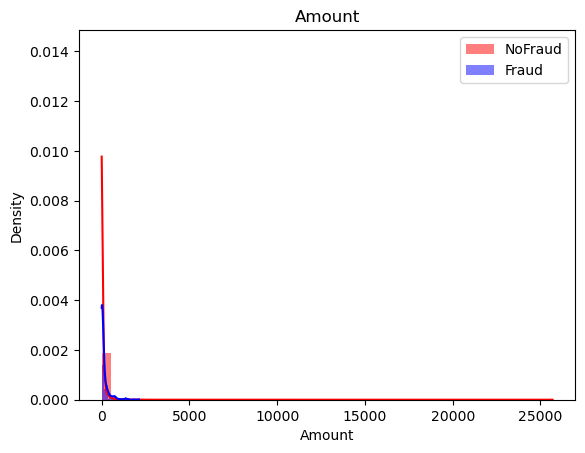

In [32]:
plot_per_class_distributions('Amount')

Из-за большого количества выбросов в классе 0 (не мошенничество), распределение свойства Amount сильно смещено в право.

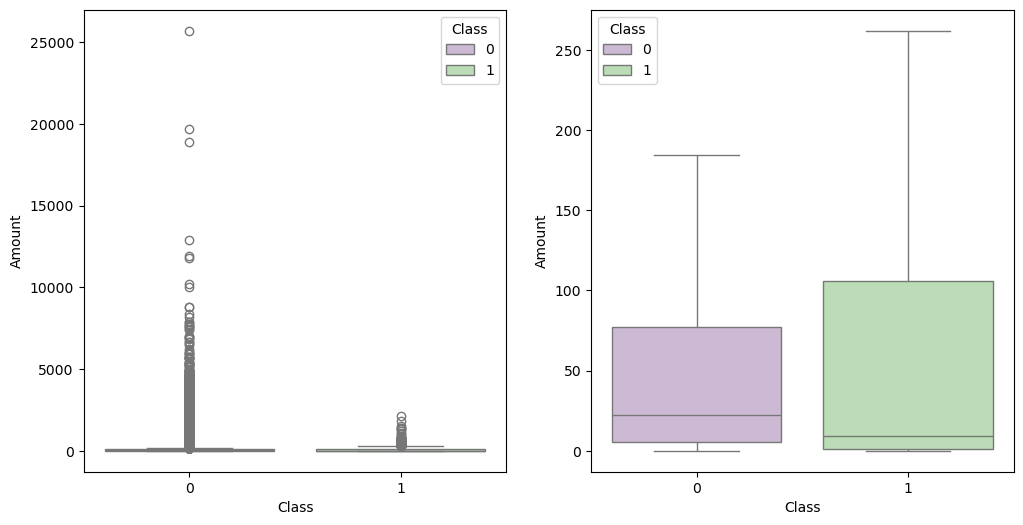

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True) # отрисовывать выбросы
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False) # не отрисовывать выбросы
plt.show()

Легитимные транзакции имеют большее среднее значение, больший Q1, меньшие Q3 и Q4 и более крупные выбросы; мошеннические транзакции имеют меньший Q1 и среднее значение, больший Q4 и меньшие выбросы.

Попробуем прологарифмировать значения свойства Amount, что бы поместить данные в более разумный диапазон значений. Как видно на картинке ниже, это помогло исправить распределения, но слишком большое перекрытие. Скорее всего это свойство не будет полезным.

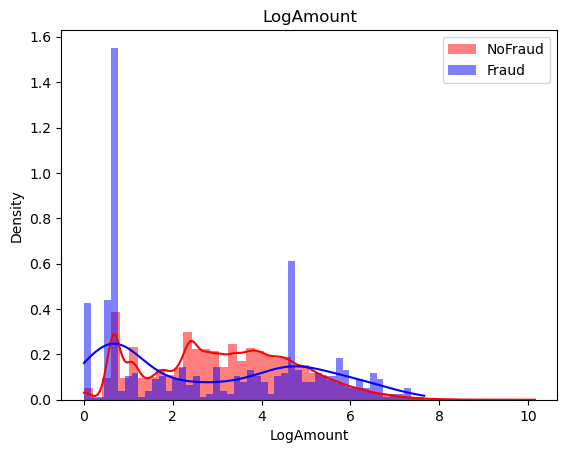

In [16]:
df['LogAmount'] = np.log1p(df['Amount'])
plot_per_class_distributions('LogAmount')

## Исследуем распределение транзакций по времени в обоих классах более детально

Датасет содержит транзакции за два дня.

In [17]:
round(df['Time'].max() / (60 * 60 * 24))

2

Покажем что транзакции упорядочены хронологически. Время проведения каждой следующей транзакции больше либо равно (транзакции проведены одновременно) текущему.

In [18]:
diff = df["Time"].diff()  # первое значение False, потому что нет предыдущего. для каждой строки diff из текущего значения вычитается предыдущее
np.all(diff.iloc[1:] >= 0) # все значения не отрицательные, это значит что время проведения каждой транзакции больше либо равно предыдущему.

True

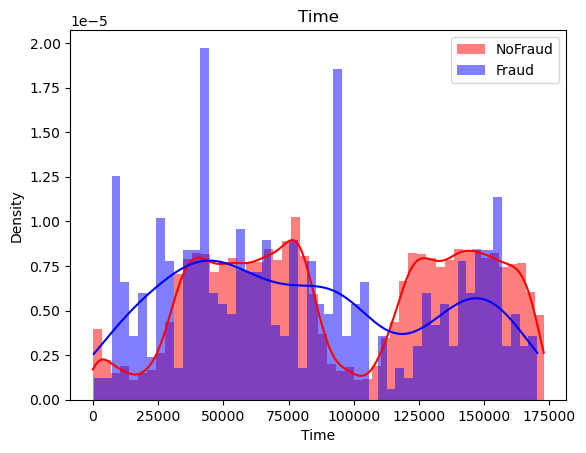

In [33]:
plot_per_class_distributions("Time")

Мошеннические транзакции распределены во времени более равномерно, чем легальные. 
Добавим новое свойство. Время суток — секунда на которой проведена транзакция. Time по модулю суток.

In [19]:
df['TimeOfDay'] = (df['Time'] % (24 * 60 * 60))

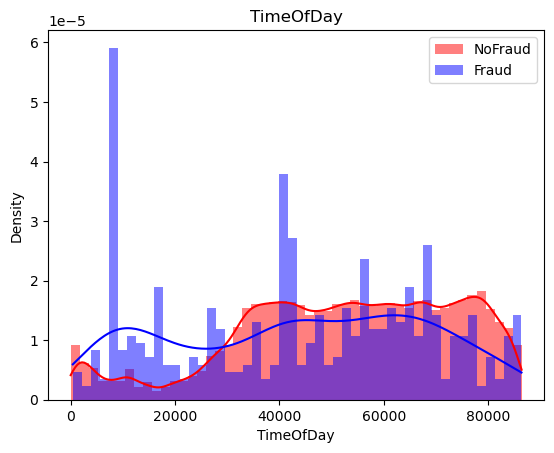

In [20]:
plot_per_class_distributions('TimeOfDay')

По графику видно что мошеннеческая активность происходит в любое время суток, а легальная подчинется циклу — больше транзакций днём. Причина по которой мы видели на графике свойства Time два холма — дневной паттерн повторяется дважды. 

### Разделение на тренировочное и тестовое множества.

Поскольку у нас данные только за два дня, мы не можем применить walk forward validation (версия cross validation для временных рядов). Тренировочное множестово всегда идёт во времени перед тестовым. Единственный способ разбить данные:  первый день — тренировочное множестово, второй — тестовое. Не имеет смысла тренировать модель на множестве меньшем одного дня, потому что модель не будет знать что происходит в оставшуюся часть дня (это важно легальная активность подчиняется циклу). Так же нет сысла тренировать на множестве большем чем день, потому что не будет возможности проверить как модель отрабатыват на тестовых данных из начала дня.

In [34]:
df_train = df[df["Time"] <= (24 * 60 * 60)]
df_test = df[df["Time"] > (24 * 60 * 60)]

## Метрики

Что бы определиться с метрикой, важно понимать контекст.

Обнаружение мошенничества это проблема бинарной классификации: система обнаружения мошенничества принимает на вход транзакцию в виде вектора свойств, и выдаёт вероятность мошенничества. Что бы получить пердсказание нужно сравнить вероятность с пороговым значением. Prediction = Probability > Threshold.


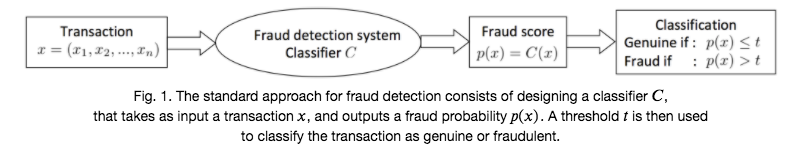

Проблема обнаружения мошенничества по своей природе является проблемой, чувствительной к ошибкам. 

### Ошибки первого и второго типов

Гипотезы:

$H_0$: Транзакция не мошенническая

$H_1$: Транзакция мошенническая

- **Ошибка первого рода** — отвергнуть гипотезу $H_0$, когда она верна. Оъбявить легитимную транзакцию мошеннической (false positive)
- **Ошибка второго рода** — не отвергнуть гипотезу $H_0$, когда она не верна. Пропустить мошенническую транзакцию. (false negative)

Популярная картинка на эту тему:

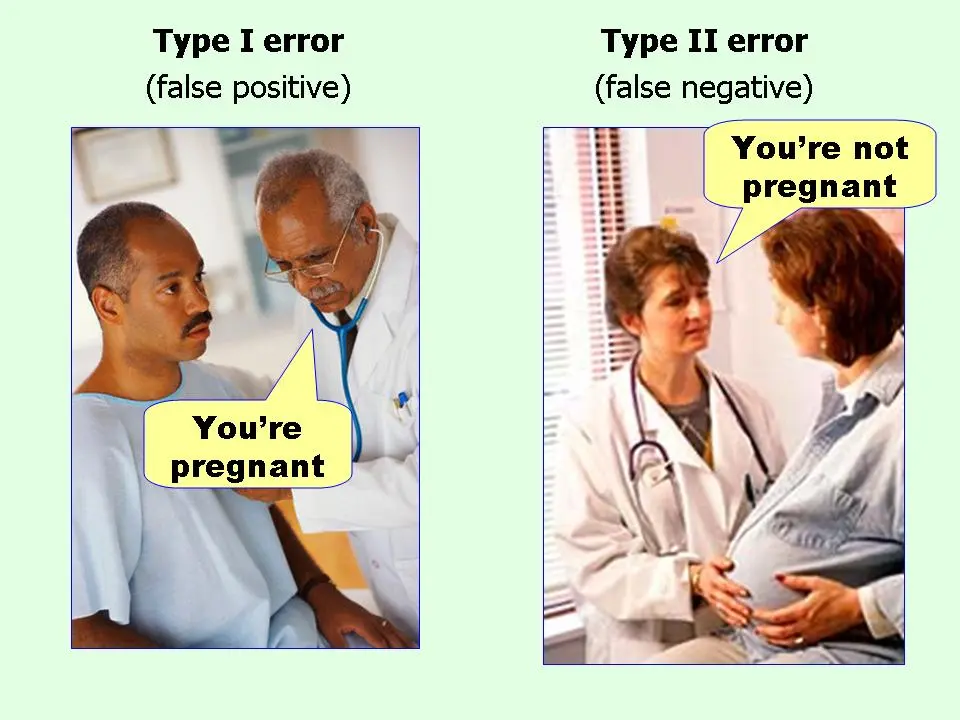


**Цена ошибки первого рода** — В случае обнаружения в режиме реального времени это влечет за собой неудобства для клиента, связанные с блокировкой его законного платежа. FPR (false positive rate) нужно держать низким потому что проверка каждого FP выполняется расследователем в ручную (нужно связаться с дрежателем карты что бы уточнить была ли транзакция мошеннической). Допустим 100 транзакций могут быть проверены каждый день. Тогда за два дня можно проверить 200 транзакций. Всего в датасете 284807 транзакций. 284807 * 0.001 = 284.8 То есть FPR выше 0,001 уже слишком высок.

**Цена ошибки второго рода** — Обычно равена объёму транзакции. Лимит расходов по карте также можно рассматривать максимальный потенциальный ущерб, к которому может привести пропущенное мошенничество. Плюс расходы на обслуживание клиентов, связанные с последующим решением проблемы, и репутация компании в целом.

Нужно оптимизировать два конфликтующих параметра. С одной стороны, необходимо максимизировать обнаружение мошеннических транзакций — recall (он же TPR). С другой стороны, минимизировать количество ложных срабатываний (false positive), то есть количество подлинных транзакций, которые ошибочно классифицируются как мошенничествo. За увеличение recall`a приходится платить ложными срабатываниями. Снизив порог, можно увеличить TPR(recall), но FPR то же возрастёт.

### Учитывая всё сказанное, какие метрики использовать?

- AUC ROC (площадь под кривой FPR vs TPR, для всех пороговых значений) подходит для получения представления о работе классификатора во всем диапазоне возможных FPR.
- AUC PR (площадь под кривой Precision-Recall, для всех пороговых значений) — Average Precision (AP). Эта метрика лучше учитывает дисбаланс данных. Сама кривая PR не монотонна, в отличии от ROC. Существует взаимно однозначное соответствие между этими кривыми.
- Значение TPR для низких значений FPR вот что важно в задаче обнаружения мошенничества. Кривая PR полезна для демонстрации эффективности систем обнаружения мошенничества при низких значениях FPR.
- [В своей книге](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_4_PerformanceMetrics/Summary.html) и на [kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) авторы датасета рекомендуют использовать эти метрики


Функция отрисовки кривых.

In [40]:
def display_both_side_by_side(true_labels, fraud_probabilities):
    FPR_list, TPR_list, _ = roc_curve(
        true_labels, fraud_probabilities, drop_intermediate=False
    )
    recalls, precisions, _ = precision_recall_curve(true_labels, fraud_probabilities)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    ax1.set_title("Receiver Operating Characteristic (ROC)")
    ax2.set_title("Precision Recall (PR) Curve")
    RocCurveDisplay(
        fpr=FPR_list,
        tpr=TPR_list,
        roc_auc=roc_auc_score(true_labels, fraud_probabilities),
    ).plot(ax1)
    PrecisionRecallDisplay(
        precision=precisions,
        recall=recalls,
        average_precision=average_precision_score(true_labels, fraud_probabilities),
    ).plot(ax2)
    plt.show()

Функция вывода метрик

In [45]:
def print_metrics(X, y, model, name):
    probs = model.predict_proba(X)
    print(f"{name} AUC ROC:", roc_auc_score(y, probs[:, 1]))
    print(f"{name} Average Precision Score (AP):", average_precision_score(y, probs[:, 1]))    
    preds = model.predict(X)
    print(f"{name} precision:", precision_score(y, preds))
    print(f"{name} recall:", recall_score(y, preds))
    print(f"{name} f1:", f1_score(y, preds))
    display_both_side_by_side(y, probs[:, 1])

## Модель

Перед нами проблема бинарной классификации с сильно несбалансированными данными.

В качестве базовой модели используем Naive Bayes из библиотеки scikit-learn. Потом добавим другие для сравнения.
"Naive" в названии алгоритма, означает предположение об условной независимости между каждой парой свойств для каждого класса. В большенстве случаев это не так. Но такие нереалистичные предположения вполне могут сойти с рук. Не требуется что бы модель полностью отражала реальность. Достаточно что бы она работала с определённой вероятностью.

Варианты алгоритма (GaussianNB, MultinomialNB, BernoulliNB ) различаются предположением, относительно распределения P(x|y). Input: x, Target: y.

Какой вариант выбрать?
- GaussianNB кажется наиболее подходящим
- Time и Amount — непрерывные величины.
- V1, V2, … V28 — полученны в результате PCA преобразования, следовательно то же непрерывные величины.

In [36]:
model = GaussianNB()

### Установим базовый уровень

Наконец, установим базовую оценку, которой можно будет сравнивать резульаты разработки.

In [68]:
features = ['TimeOfDay', 'Amount'] + [f"V{i}" for i in range(1, 29)]
print(features)

['TimeOfDay', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


Тренеруем модель

In [69]:
model.fit(df_train[features], df_train['Class'])

GaussianNB()

test AUC ROC: 0.9734110846351349
test Average Precision Score (AP): 0.10355392391626243
test precision: 0.07832422586520947
test recall: 0.8151658767772512
test f1: 0.1429164935604487


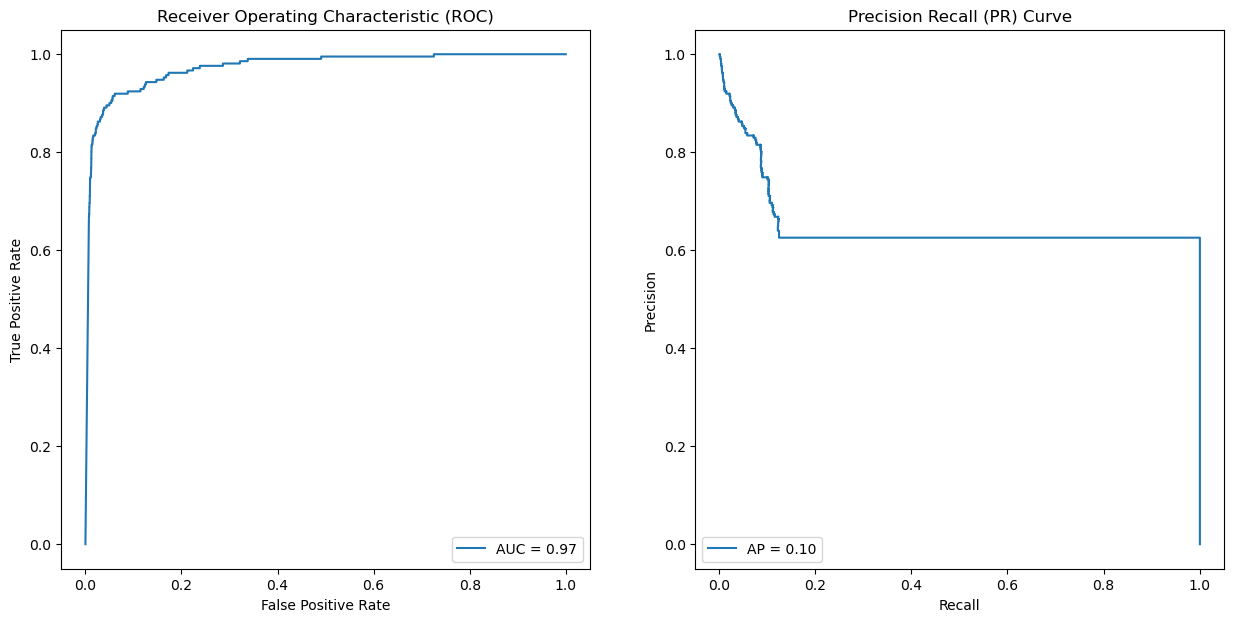

In [70]:
print_metrics(df_test[features], df_test['Class'], model, name='test')

Из совйств V1 — V28, выберем свойства с лучшим разделением по классам. Выше мы рассматривали распределения этих свойств. У некоторых свойств было хорошее разделение по классам, другие сильно перекрывались. Я выбрал несколько свойств, которые на мой взгляд, имеют хорошее разделение.

test AUC ROC: 0.9808305671186679
test Average Precision Score (AP): 0.3110435568587226
test precision: 0.15156794425087108
test recall: 0.8246445497630331
test f1: 0.2560706401766005


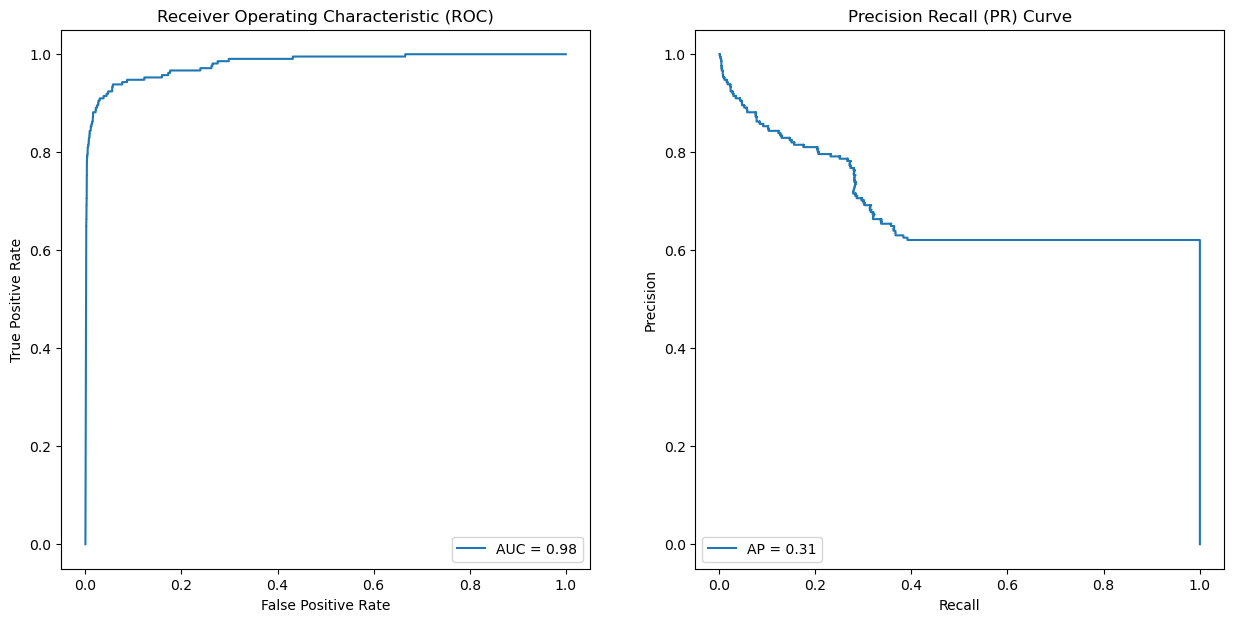

In [67]:
features = [3, 4, 7, 10, 11, 12, 14, 16, 17]
features = ['TimeOfDay','Amount'] + [f"V{i}" for i in features]
model.fit(df_train[features], df_train['Class'])
print_metrics(df_test[features], df_test['Class'], model, name='test')

В данном случае, отказ от бесполезных свойств улучшил производительность. Стало сильно лучше. AP увеличилась с 0.10 до 0.31.

## Промежуточные итоги

- Это отличный датасет для изучения проблемы двоичной классификации несбалансированных данных.
- Разобрался с метриками.
- Постороил базовую модель. ROC: 0.98, AP: 0.31

## Дальнейшие шаги

- Добавить больше несколько классификаторов. Сравнить результаты.
- Сгенериравть датасет большего объёма (7 дней) с помощью [симуляции](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html) от авторов датасета. Свойства будут доступны в явном виде.
- feature engineering
- [Validation strategies](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_5_ModelValidationAndSelection/ValidationStrategies.html)